In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display 
from sklearn.model_selection import train_test_split 
import lightgbm as lgb


In [2]:
def dateparse(d):
    return pd.to_datetime(d)

In [195]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data/', 'trainset.csv'),
                        encoding= 'unicode_escape', low_memory=False, parse_dates=['measured_at'], date_parser=dateparse)
df = df.drop(columns=['index','measured_at'])
#df['error'] = (df['error_category'] != 'NO_ERROR').astype(int)


In [196]:
df['error'] = (df['error_category'] != 'NO_ERROR').astype(int)

In [197]:
#df['error'] = 0
err = {'error_category': {'ERROR=12':0, 'ERROR=17':1, 'ERROR=3':2, 'ERROR=5': 3, 'ERROR=19': 4, 'ERROR=24':5, 
                          'ERROR=28':6, 'ERROR=8': 7, 'ERROR=20':8, 'ERROR=31':9, 'ERROR=30':10, 'ERROR=22':11,
                          'ERROR=25':12, 'ERROR=7':13, 'ERROR=27':14, 'ERROR=29':15, 'ERROR=23':16, 'NO_ERROR':-1}}
df = df.replace(err)




In [198]:
df.error_category.value_counts()

-1     1272609
 0       47724
 1       21651
 2       10224
 3        4893
 4        3743
 5        1771
 6        1494
 7        1081
 8         787
 9         495
 10        409
 11        141
 12        108
 13         32
 14         22
 15          4
 16          2
Name: error_category, dtype: int64

In [199]:
params1 = {
    'n_estimators': 1000,
    'colsample_bytree':0.8,
    #"early_stopping_rounds":[10], 
    'objective': 'binary',
    'max_depth': 10,
    'num_leaves': 100,
    'metric' : 'logloss',
    #'reg_alpha': [1.1, 1.2, 1.3],
    #'reg_lambda': [1.1, 1.2, 1.3],
    'learning_rate':0.1,
    #'is_unbalance': ['True']
    'scale_pos_weight':10,
    #'min_split_gain': [0.3, 0.4],
    'subsample': 0.9,
    #'subsample_freq': [20]
}

In [200]:
y1 = df.error
y2 = df.error_category
X = df.drop(columns=['error','error_category'])

In [207]:
df.query('error==1')

,turbine_id,wind_speed,power,nacelle_direction,wind_direction,rotor_speed,generator_speed,temp_environment,temp_hydraulic_oil,temp_gear_bearing,cosphi,blade_angle_avg,hydraulic_pressure,park_id,error_category,error
428,11,1.091667,0.987200,305.8,307.7,0.993289,0.833333,8.0,39.0,56.0,0.99,6.5,195.8,1,3,1
429,11,1.016667,0.931600,308.6,311.0,0.993289,0.832837,7.0,40.0,56.0,0.99,4.5,196.1,1,3,1
430,11,1.041667,0.981450,313.5,316.0,0.993289,0.833829,7.0,41.0,57.0,0.99,4.6,196.0,1,3,1
497,11,1.041667,0.996450,247.6,243.7,NaN,0.833333,6.0,33.0,51.0,0.99,6.1,196.0,1,3,1
498,11,1.100000,0.997700,244.0,242.8,NaN,0.833829,6.0,34.0,51.0,0.99,7.0,196.1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365699,29,0.307692,-0.004000,75.7,72.5,0.050000,0.033800,21.0,44.0,53.0,-0.50,71.0,246.9,2,2,1
1365796,29,0.253846,-0.006121,60.3,57.4,0.425000,0.370800,11.0,42.0,47.0,-0.80,12.3,247.2,2,4,1
1365797,29,0.261538,-0.007636,60.3,57.2,NaN,0.344200,12.0,42.0,47.0,-0.90,12.6,248.3,2,4,1
1366659,29,0.376923,0.072576,14.5,12.8,0.550000,0.488400,11.0,43.0,62.0,0.70,9.1,246.9,2,5,1


In [201]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.set_params(**params1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y1,
                                                    stratify=y1,
                                                    test_size=0.2,
                                                    random_state=11) 

In [202]:
model.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.8, max_depth=10, metric='logloss',
               n_estimators=1000, num_leaves=100, objective='binary',
               scale_pos_weight=10, subsample=0.9)

In [208]:
y_pred = model.predict_proba(X_test)

In [211]:
ind = np.argmax(y_pred, axis=1)

In [212]:
X_test = X_test[ind==1]


In [229]:
y2_test = y_test[ind==1]

In [120]:
#df_err = df[df.error_category > 0]
#y = df_err.error_category
#X = df_err.drop(columns=['error_category'])

In [215]:
params2 = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class':17,
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            #'num_leaves': 2**11-1,
            #'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            #'max_bin': 100,
            'n_estimators': 5000,
            'boost_from_average': False,
            "random_seed":42}

In [216]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train,
                                            y_train,
                                            stratify=y_train,
                                            test_size=0.2,
                                            random_state=11)

#X_val, X_test, y_val, y_test = train_test_split(X_,
#                                                    y_,
#                                                    #stratify=y_,
#                                                    test_size=0.7,
#                                                    random_state=11)  


In [219]:
X_train2.columns

Index(['turbine_id', 'wind_speed', 'power', 'nacelle_direction',
       'wind_direction', 'rotor_speed', 'generator_speed', 'temp_environment',
       'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi', 'blade_angle_avg',
       'hydraulic_pressure', 'park_id'],
      dtype='object')

In [183]:
#mymodel = lgb.LGBMClassifier(n_estimators=5)
#mymodel.fit(X_train, y_train)

LGBMClassifier(n_estimators=5)

In [220]:
train_data = lgb.Dataset(data=X_train2[X.columns],
                         label=y_train2,
                         free_raw_data=False)

valid_data = lgb.Dataset(data=X_val[X.columns],
                         label=y_val,
                         free_raw_data=False)

In [221]:
model_gbm = lgb.train(params2, train_data, valid_sets=[valid_data],
                  num_boost_round=2000, early_stopping_rounds=50,
                  verbose_eval=25)

C:\Users\PMoes\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\PMoes\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\PMoes\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 875001, number of used features: 14
Training until validation scores don't improve for 50 rounds
[25]	valid_0's multi_logloss: 0.124085
[50]	valid_0's multi_logloss: 0.0465858
[75]	valid_0's multi_logloss: 0.0273579
[100]	valid_0's multi_logloss: 0.0215396
[125]	valid_0's multi_logloss: 0.0192385
[150]	valid_0's multi_logloss: 0.0181926
[175]	valid_0's multi_logloss: 0.0176081
[200]	valid_0's multi_logloss: 0.0172305
[225]	valid_0's multi_logloss: 0.0169289
[250]	valid_0's multi_logloss: 0.0166899
[275]	valid_0's multi_logloss: 0.0164573
[300]	valid_0's multi_logloss: 0.0162833
[325]	valid_0's multi_logloss: 0.0161355
[350]	valid_0's multi_logloss: 0.0160167
[375]	valid_

In [222]:
y_pred = model_gbm.predict(X_test, raw_score=True)

In [224]:
pred = np.argmax(y_pred, axis=1)

In [231]:
y2_test[:10]

1044407    1
604363     1
703854     1
547483     1
335383     1
1281906    1
187472     1
586513     1
1258858    1
1212125    1
Name: error, dtype: int32

In [232]:
pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [158]:
pd.Series(pred).value_counts()

1     4651
2     2176
3      996
4      775
5      327
6      311
7      212
8      162
9      101
10      79
12      24
11      21
13       6
dtype: int64

In [184]:
y_pred2 = mymodel.predict(X_test)

In [170]:
pred = np.argmax(y_pred2, axis=1)

In [189]:
y_pred2

array([2, 1, 1, ..., 1, 1, 1], dtype=int64)

In [230]:
from sklearn import metrics 
#print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test's f1: {metrics.f1_score(y2_test, pred, average='micro'):.5f}")
#print(f"Test's AUPRC: {metrics.average_precision_score(y_test, y_pred):.5f}")

Test's f1: 0.96789


In [32]:
from sklearn import metrics
def confusion_matrix(y_test, y_pred):
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = [0,1], columns=[0,1])
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

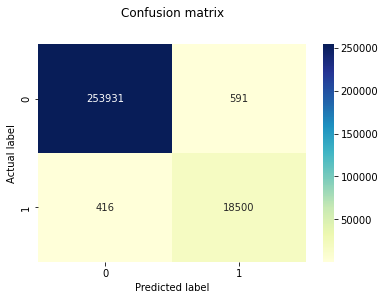

In [33]:
confusion_matrix(y_test,y_pred2)

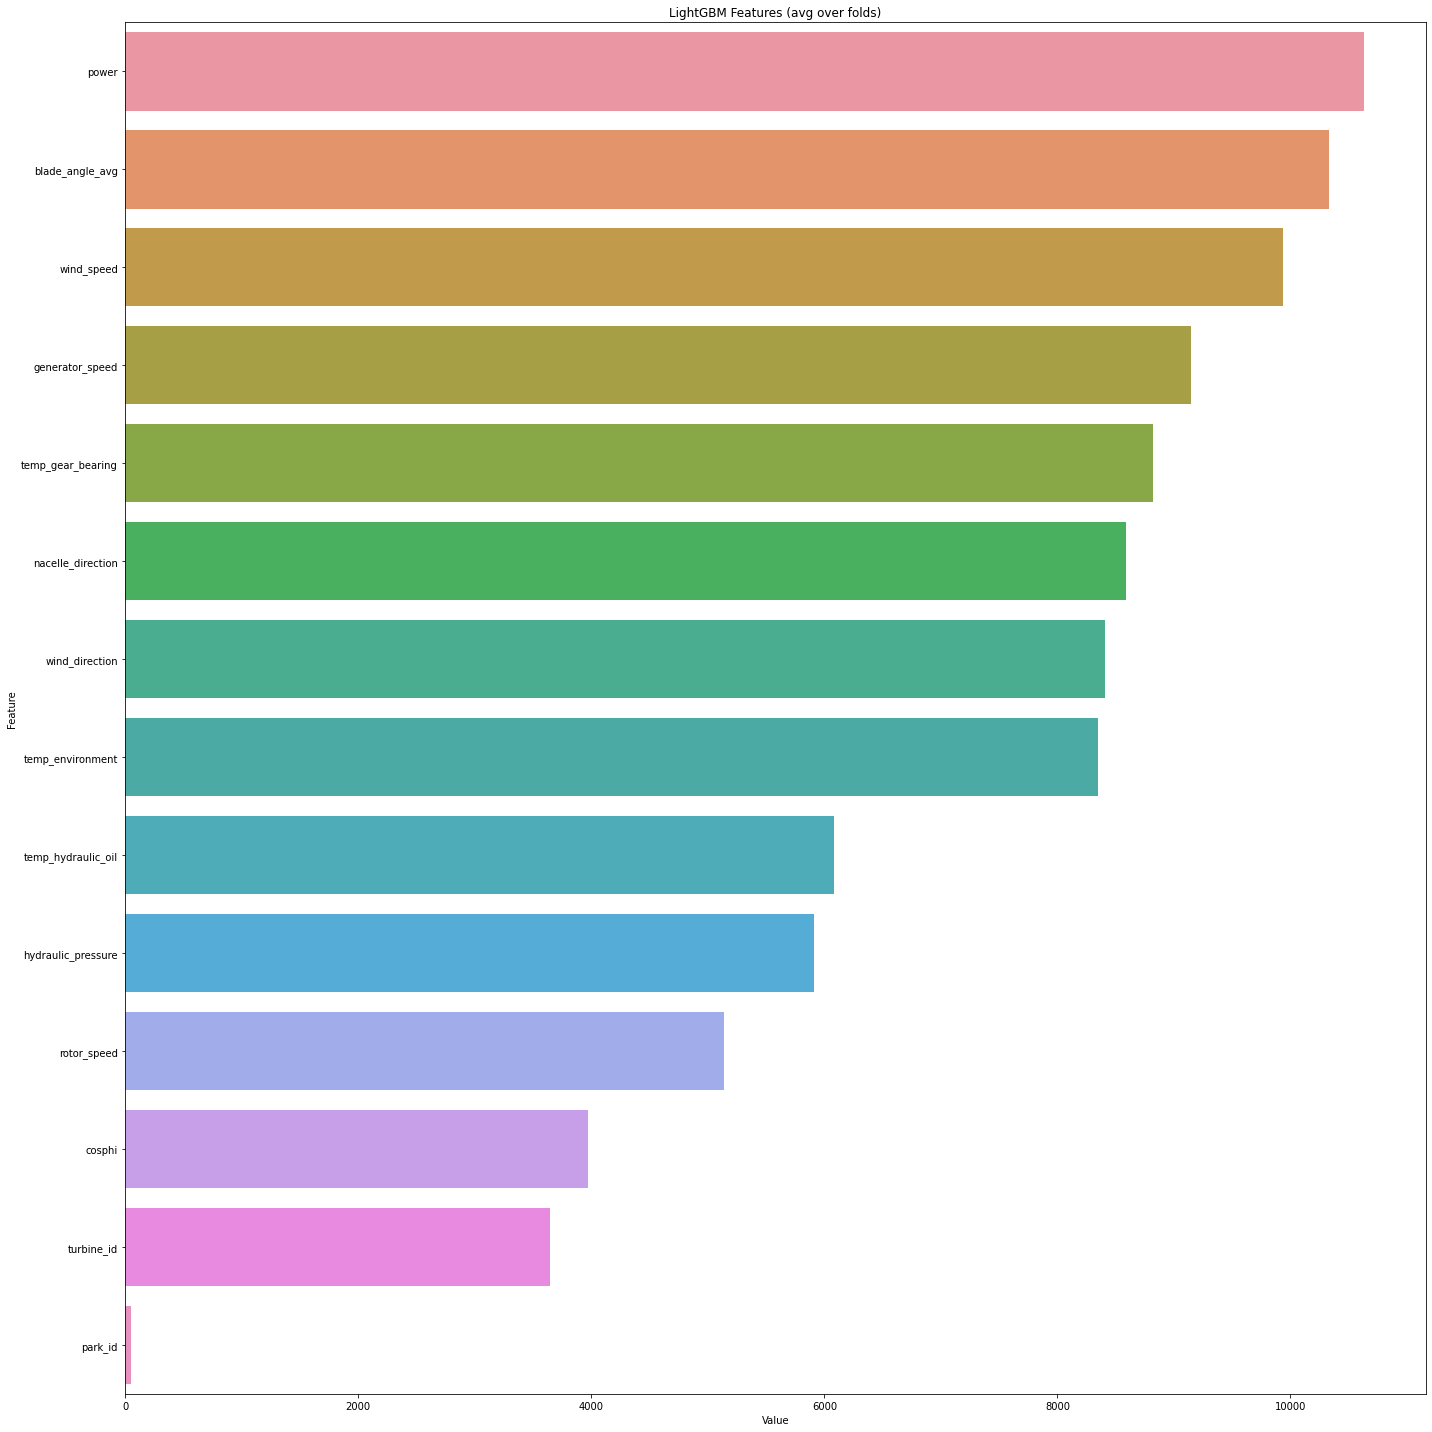

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()